In [1]:
import csv
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import h5py
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Lambda, Conv2D, MaxPooling2D, Cropping2D, Dropout

%matplotlib inline

Using TensorFlow backend.


In [2]:
lines = []
with open('c:/dl/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [3]:
def read_rgb_image(image_file):
    img = cv.imread(image_file)
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

# 1. Nvidia model 1
#### Image - Left lane, right lane and middle lane. Loss = mse, optimizer= adam, activation function = tanh, 

Train on 49948 samples, validate on 12488 samples
Epoch 1/10
49948/49948 [==============================] - 315s 6ms/step - loss: 0.0747 - val_loss: 0.0439
Epoch 2/10
49948/49948 [==============================] - 300s 6ms/step - loss: 0.0370 - val_loss: 0.0528
Epoch 3/10
49948/49948 [==============================] - 300s 6ms/step - loss: 0.0340 - val_loss: 0.0442
Epoch 4/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0321 - val_loss: 0.0487
Epoch 5/10
49948/49948 [==============================] - 304s 6ms/step - loss: 0.0334 - val_loss: 0.0415
Epoch 6/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0326 - val_loss: 0.0505
Epoch 7/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0324 - val_loss: 0.0400
Epoch 8/10
49948/49948 [==============================] - 301s 6ms/step - loss: 0.0306 - val_loss: 0.0407
Epoch 9/10
49948/49948 [==============================] - 302s 6ms/step - loss: 0.0279 - val_loss: 0.0395
Epoch 10/10
49948/49948 [==============================] - 302s 6ms/step - loss: 0.0262 - val_loss: 0.0403

In [5]:
center_images = []
steering = []
for line in lines:
    correction = 0.2
    image_file = line[0]
    steering_center = float(line[3])
    if (steering_center > -0.00001 and steering_center < 0.00001):
        choice = np.random.choice(3)
        if choice != 0:
            continue
    center_image = read_rgb_image(line[0])
    left_image = read_rgb_image(line[1])
    right_image = read_rgb_image(line[2])
    center_images.append(center_image)
    center_images.append(left_image)
    center_images.append(right_image)
    steering.append(steering_center)
    steering.append(steering_center + correction)
    steering.append(steering_center - correction)

In [6]:
original_training_image = len(center_images)

In [7]:
#augmenting the training data by fliping images and their measurement
for i in range(original_training_image):
    center_images.append(np.fliplr(center_images[i]))
    steering.append(-steering[i])

In [8]:
center_images = np.array(center_images)
steering = np.array(steering)

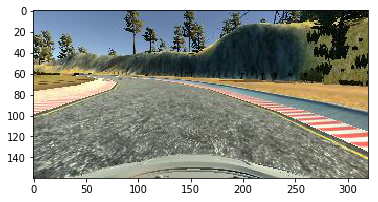

In [9]:
plt.imshow(center_images[0])

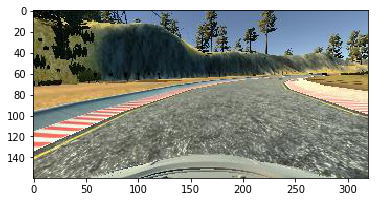

In [10]:
plt.imshow(np.fliplr(center_images[0]))

In [11]:
center_images[0].shape

(160, 320, 3)

In [12]:
len(center_images)

32958

In [13]:
def convert_RGB_to_GRAY(image):
    rgb_img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #rg_img = cv.normalize(rgb_img, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    return rgb_img[:,:, np.newaxis]

In [14]:
def preprocess_image(x):
    gray_image = lambda t : convert_RGB_to_GRAY(t)
    
    x = np.array(list(map(gray_image, x)))
    x = x.astype(float)/128.0
    return x

In [15]:
#center_images = preprocess_image(center_images)

In [16]:
def Lent_model(in_shape, dropout):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=in_shape))
    model.add(Cropping2D(cropping=((50,20),(0,0))))
    model.add(Conv2D(6,(5,5), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(16, (5,5), padding='valid'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
    
    return model

In [17]:
def Nvidia_model(in_shape, dropout):
    model = Sequential()
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=in_shape))
    model.add(Cropping2D(cropping=((40,20),(0,0))))

    model.add(Conv2D(24, (5, 5), padding='valid', activation = 'tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(36, (5, 5), padding='valid', activation = 'tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(48, (5, 5), padding='valid', activation = 'tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64,(3, 3), padding='valid', activation = 'tanh'))

    model.add(Conv2D(64,(3,3), padding='valid', activation = 'tanh'))

    model.add(Flatten())
    
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(50))
    model.add(Dropout(0.1))
    model.add(Dense(10))
    model.add(Dense(1))
    
    model.summary();
    
    return model

In [18]:
#center_images, steering = shuffle(center_images, steering)

In [19]:
model = Nvidia_model(center_images[0].shape, dropout=0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 100, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 316, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 154, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 77, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 73, 48)        43248     
__________

In [20]:
model.compile(optimizer='adam', loss='mse')

In [21]:
train_history = model.fit(center_images, steering, validation_split=0.20, shuffle=True, epochs=10)

Train on 26366 samples, validate on 6592 samples
Epoch 1/10
26366/26366 [==============================] - 159s 6ms/step - loss: 0.0974 - val_loss: 0.0793
Epoch 2/10
26366/26366 [==============================] - 156s 6ms/step - loss: 0.0531 - val_loss: 0.0673
Epoch 3/10
26366/26366 [==============================] - 157s 6ms/step - loss: 0.0455 - val_loss: 0.0753
Epoch 4/10
26366/26366 [==============================] - 157s 6ms/step - loss: 0.0410 - val_loss: 0.0721
Epoch 5/10
26366/26366 [==============================] - 158s 6ms/step - loss: 0.0388 - val_loss: 0.0767
Epoch 6/10
26366/26366 [==============================] - 158s 6ms/step - loss: 0.0379 - val_loss: 0.0737
Epoch 7/10
26366/26366 [==============================] - 156s 6ms/step - loss: 0.0371 - val_loss: 0.0690
Epoch 8/10
26366/26366 [==============================] - 157s 6ms/step - loss: 0.0356 - val_loss: 0.0699
Epoch 9/10
26366/26366 [==============================] - 157s 6ms/step - loss: 0.0346 - val_loss: 0.06

In [22]:
train_history.history

{'loss': [0.097433694442835145,
  0.053085949974135835,
  0.045548567399049146,
  0.040999352320466934,
  0.038755080615123179,
  0.037924468554886993,
  0.037090899379105723,
  0.035565295154449929,
  0.034621261263980151,
  0.032835120192940805],
 'val_loss': [0.079274585793807528,
  0.067278846466543099,
  0.075335888678063317,
  0.072087864226489828,
  0.076696468589519992,
  0.073710545128916657,
  0.069029173246376863,
  0.069947992006172105,
  0.067927622218227499,
  0.076572971178887825]}

In [23]:
model.save('model_Nvidia_adam_mse_sampled_straightlane.h5')

In [24]:
model.predict(center_images[:2])

array([[ 0.10113665],
       [ 0.02534958]], dtype=float32)

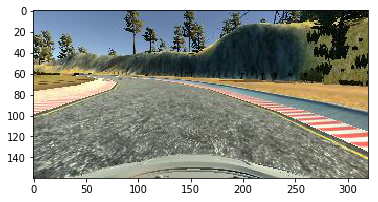

In [25]:
plt.imshow(center_images[0])

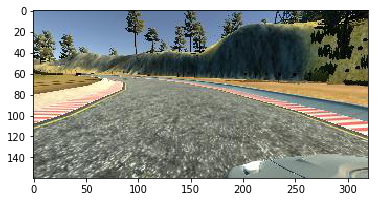

In [26]:
plt.imshow(center_images[1])